# Physics-informed machine learning for Acoustics
Summer School - Forum Acusticum 2025

Mirco Pezzoli, Politecnico di Milano.

This code is based on tutorial by Prof. Ben Moseley from ETH.
Find out more [here](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)

Read PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


Let's code a PINN using PyTorch to simulate a simple 1D physical system and solve the associated PDE.


In [ ]:
# We start importing some libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Problem description

The system to be simulated by the PINN is a **damped harmonic oscillator**:

<img src="https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/oscillator.gif?raw=1" width="500">

Basically, we are interested in simulating the displacement of the mass on a spring over time.
The motion of the mass, is described by its dispacement $U(t)$ as a function of time through the following differential equation:
$$
m \dfrac{d^2 U}{d t^2} + \mu \dfrac{d U}{d t} + kU = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, namely, when the oscillation is slowly damped by friction.
This scenario is valid when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
The analytical solution can thus be found given boundary conditions

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

and it reads as

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


For a more detailed derivation, please check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Task
We will use a PINN to **simulate** the oscillator system using the initial conditions and the governing PDE.

## Setup

Let's star with some helpers

In [ ]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class MLP(nn.Module):
    '''We defines a standard fully-connected network in PyTorch
    n_in: number of inputs
    n_out: numer of outputs
    n_hidden: number of neurons in hidden layers
    n_layers: number of hidden layers'''

    def __init__(self, n_in, n_out, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_hidden),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(n_hidden, n_hidden),
                            activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x = self.fcs(x) # First layer
        x = self.fch(x) # Hidden layers
        x = self.fce(x) # Last layer (typically linear)
        return x

## Task: Forward problem, i.e., train a PINN to solve PDE

#### Goal

Our goal is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: initial conditions of the system and the sampled domain
- Outputs: estimate of the solution, $U(t)$

#### Idea

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
g(t;\theta) \approx U(t)~,
$$

where $\theta$ are the learnable parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (g(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d g}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] g(t_{i};\theta)  \right)^2
$$

For this example, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function are the **boundary loss**, and they are used to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $U(t=0)=1$ and $U'(t=0)=0$.

The second term in the loss function is the **physics loss** or **PDE loss**, and it is adopted to penalize deviations of the PINN solution with respect to the underlying differential equation at a set of training points $\{t_i\}$ spanning the domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

The gradients of the pinn will computed using autodifferentiation (`torch.autograd`). To know more about how autodifferentiation works in pytorch visit [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.


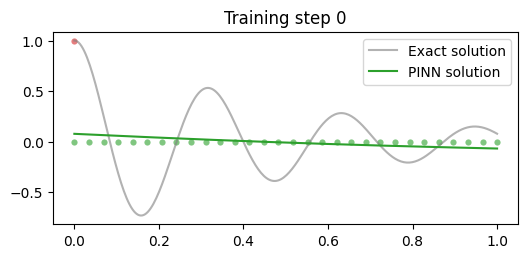

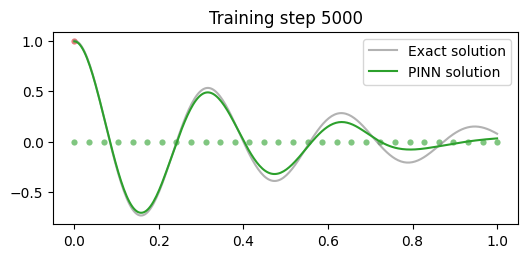

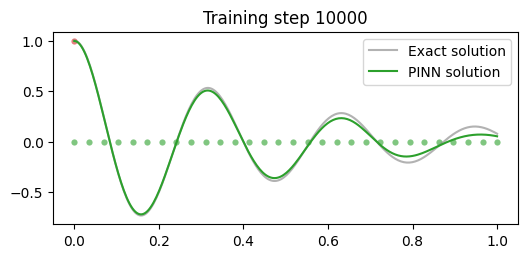

In [ ]:
torch.manual_seed(123)

# define a MLP to train
# TODO: write code here

# define boundary points, for the boundary loss
# TODO: write code here

# define training points over the entire domain, for the physics loss
# TODO: write code here

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
U_exact = exact_solution(d, w0, t_test)

# Loss balancing hyperparameters used to multiply the loss terms:
lambda1, lambda2 = 1e-1, 1e-4

# Use the Adam optimizer with 0.001 learning rate
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

# TRAINING LOOP!!
for i in range(12001):
    optimiser.zero_grad()



    # compute boundary loss
    # TODO: write code here

    loss1 =

    dUdt = torch.autograd.grad(U, t_boundary, torch.ones_like(U), create_graph=True)[0]
    loss2 =

    # compute physics loss
    # TODO: write code here
    U =

    # compute derivates
    dUdt = torch.autograd.grad(U, t_physics, torch.ones_like(U), create_graph=True)[0]
    d2Udt2 = torch.autograd.grad(dUdt, t_physics, torch.ones_like(dUdt), create_graph=True)[0]
    loss3 =

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss =
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 1000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        U = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    U_exact[0,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], U_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], U[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## Experiments
You can play with the parameters of the system obtaining different solutions e.g., frequency of oscillation $\omega_0$.

You should discover that the PINN struggles to converge at high frequencies. This is one of the **major limitations** of PINNs.
Can you guess why this has happened?
